# 0.) Import the Credit Card Fraud Data From CCLE

In [1]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np

In [2]:
drive.mount('/content/gdrive/', force_remount = True)

Mounted at /content/gdrive/


In [3]:
df = pd.read_csv("/content/gdrive/MyDrive/Econ441B/fraudTest.csv", header = 0)

In [4]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [5]:
df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

# 1.) Use scikit learn preprocessing to split the data into 70/30 in out of sample

In [6]:
from sklearn.model_selection import train_test_split

col_list = ["trans_date_trans_time", "category", "gender", "zip", "amt", "city_pop", "is_fraud"]

# Split the data into features (X) and target (y)
df = df[col_list].copy()
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])
df["sec"] = [i.second for i in df["trans_date_trans_time"]]

X = pd.get_dummies(df, ["category", "gender"]).drop(["trans_date_trans_time", "is_fraud"], axis = 1)
y = df['is_fraud']

# Split the data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2.) Make three sets of training data (Oversample, Undersample and SMOTE)

In [7]:
import pandas as pd
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [8]:
# Oversample using RandomOverSampler
ros = RandomOverSampler(sampling_strategy='minority')
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train, y_train)
df_resampled_ros = pd.DataFrame(X_resampled_ros)
df_resampled_ros['is_fraud'] = y_resampled_ros

# Undersample using RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='majority')
X_resampled_rus, y_resampled_rus = rus.fit_resample(X_train, y_train)
df_resampled_rus = pd.DataFrame(X_resampled_rus)
df_resampled_rus['is_fraud'] = y_resampled_rus

# Synthetic oversample using SMOTE
smote = SMOTE(sampling_strategy='minority')
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train, y_train)
df_resampled_smote = pd.DataFrame(X_resampled_smote)
df_resampled_smote['is_fraud'] = y_resampled_smote

# 3.) Train three logistic regression models 

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Train Logistic Regression model on oversampled data
log_reg_ros = LogisticRegression()
log_reg_ros.fit(df_resampled_ros.drop('is_fraud', axis=1), df_resampled_ros['is_fraud'])

# Train Logistic Regression model on undersampled data
log_reg_rus = LogisticRegression()
log_reg_rus.fit(df_resampled_rus.drop('is_fraud', axis=1), df_resampled_rus['is_fraud'])

# Train Logistic Regression model on SMOTE oversampled data
log_reg_smote = LogisticRegression()
log_reg_smote.fit(df_resampled_smote.drop('is_fraud', axis=1), df_resampled_smote['is_fraud'])

LogisticRegression()

# 4.) Test the three models

In [10]:
# Predict and evaluate accuracy for oversampled data
y_pred_ros = log_reg_ros.predict(X_test)
accuracy_ros = accuracy_score(y_test, y_pred_ros)
cm_ros = confusion_matrix(y_test, y_pred_ros)

# Predict and evaluate accuracy for undersampled data
y_pred_rus = log_reg_rus.predict(X_test)
accuracy_rus = accuracy_score(y_test, y_pred_rus)
cm_rus = confusion_matrix(y_test, y_pred_rus)

# Predict and evaluate accuracy for SMOTE oversampled data
y_pred_smote = log_reg_smote.predict(X_test)
accuracy_smote = accuracy_score(y_test, y_pred_smote)
cm_smote = confusion_matrix(y_test, y_pred_smote)

# Print accuracy and confusion matrix for each model
print("Accuracy of oversampled data: ", accuracy_ros)
print("Confusion Matrix of oversampled data: \n", cm_ros)

print("Accuracy of undersampled data: ", accuracy_rus)
print("Confusion Matrix of undersampled data: \n", cm_rus)

print("Accuracy of SMOTE oversampled data: ", accuracy_smote)
print("Confusion Matrix of SMOTE oversampled data: \n", cm_smote)

Accuracy of oversampled data:  0.8321216919791742
Confusion Matrix of oversampled data: 
 [[138241  27835]
 [   153    487]]
Accuracy of undersampled data:  0.8882950646608604
Confusion Matrix of undersampled data: 
 [[147605  18471]
 [   152    488]]
Accuracy of SMOTE oversampled data:  0.8308920559514383
Confusion Matrix of SMOTE oversampled data: 
 [[138036  28040]
 [   153    487]]


# 5.) Which performed best in Out of Sample metrics?

The model trained on the oversampled data performence the best in out of sample metrics.

# 6.) Pick two features and plot the two classes before and after SMOTE.

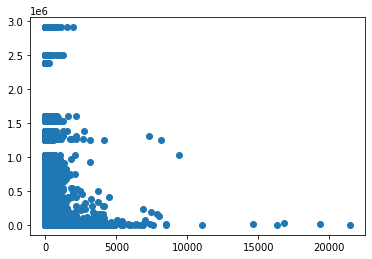

In [14]:
import matplotlib.pyplot as plt
plt.scatter(X_train.amt, X_train.city_pop)
plt.show()

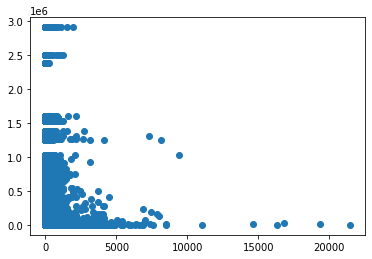

In [15]:
plt.scatter(X_resampled_smote.amt, X_resampled_smote.city_pop)
plt.show()